# User-defined adaptive time-stepping methods

_Highlights_
- building an adaptive Adams-Bashforth2 method for adaptive time-stepping
- using details of the solution (instead of an error estimate) to control the time step

## Introduction

This example solves the cannonball trajectory problem used in another notebook that introduced adaptive time-stepping and custom termination rules (stopping integration when the cannonball hits the ground).
Here we build an explicit linear multistep method that can solve this problem with adaptive time-stepping.
The class is coded completely in our notebook and used with Spitfire internal time-stepping and step control algorithms as if it were provided out of the box.

Following that we code another new stepper that uses an estimate of time-stepper error when the cannonball is first launched but later switches to a heuristic that reduces the step size as the object nears the ground. This enables us to obtain very accurate measures of the distance the object travels (the impact point) without slowing down the entire simulation. This is a very unusual way to control a time step but the abstraction in Spitfire's time integration framework allows it.

First we'll do some setup - see the first demo with cannonball trajectories to learn more about this code.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

rf = 1.23                         # fluid density, kg/m3
ro = 7.86e3                       # object (cannonball) density, kg/m3
g = 9.8                           # gravitational constant, m/s2
r = 4. * 2.54 / 100.              # cannonball radius, m
A = 4. * np.pi * r * r            # surface area, m2
V = np.pi * r * r * r * 4. / 3.   # volume, m3
    
def ode_rhs(t, q, c_d):
    vel_x = q[2]
    vel_y = q[3]
    
    f = 0.5 * rf * c_d * A / (ro * V)
    
    return np.array([vel_x,
                     vel_y,
                     -f * vel_x * vel_x,
                     -g - f * vel_y * vel_y])

def object_has_landed(t, state, *args, **kwargs):
    vel_y = state[1]
    pos_y = state[3]
    return pos_y < r and vel_y < 0

## Variable-step AB2 Method

We now implement the variable-step second-order Adams-Bashforth method. In a previous notebook we coded up the fixed-step variant which is a little simpler. For the variable step method the update is

$$ y^{n+1} = y^{n} + (\Delta t)^n\left((1-C) r(t^n,y^n) + C r(t^{n-1},y^{n-1})\right) $$

where $C = -(\Delta t)^n/(2(\Delta t)^{n-1})$.

In order to use this method for adaptive time-stepping, we need some way to estimate the error of a time step. A simple, asymptotically correct way to do this is to compute a first-order update with the forward Euler method,

$$ y^{n+1,FE} = y^{n} + (\Delta t)^n r(t^n,y^n)$$

and then use the difference, $|y^{n+1}-y^{n+1,FE}|$, as the error estimate. To feed this to Spitfire we then add the `temporal_error` field in the `StepOutput` instance returned by `single_step`, as in the code below.

In [7]:
from spitfire.time.methods import StepOutput, TimeStepper

class AB2FE(TimeStepper):
    def __init__(self):
        super().__init__(name='Adams-Bashforth-2 w/FE error', order=2)
        self._rhs_nm1 = None
        self._dt_nm1 = None

    def single_step(self, state, t, dt, rhs, *args, **kwargs):
        rhs_n = rhs(t, state)
        
        if self._rhs_nm1 is None:
            update = dt * rhs_n   # if first step, use Forward Euler
            error = 1e-2          # an arbitrary value that only impacts the first step
        else:
            C = -0.5 * dt / self._dt_nm1
            update = dt * ((1. - C) * rhs_n + C * self._rhs_nm1)
            error = np.linalg.norm(update - dt * rhs_n, ord=np.Inf)
        
        self._dt_nm1 = np.copy(dt)
        self._rhs_nm1 = np.copy(rhs_n)
        return StepOutput(solution_update=update, temporal_error=error)

Now we'll solve the problem with our new `AB2FE` method and Spitfire's `AdaptiveERK21HeunEuler` method that does a similar technique (involving the trapezoidal and forward Euler methods) to make sure our implementation looks good.

<IPython.core.display.Javascript object>


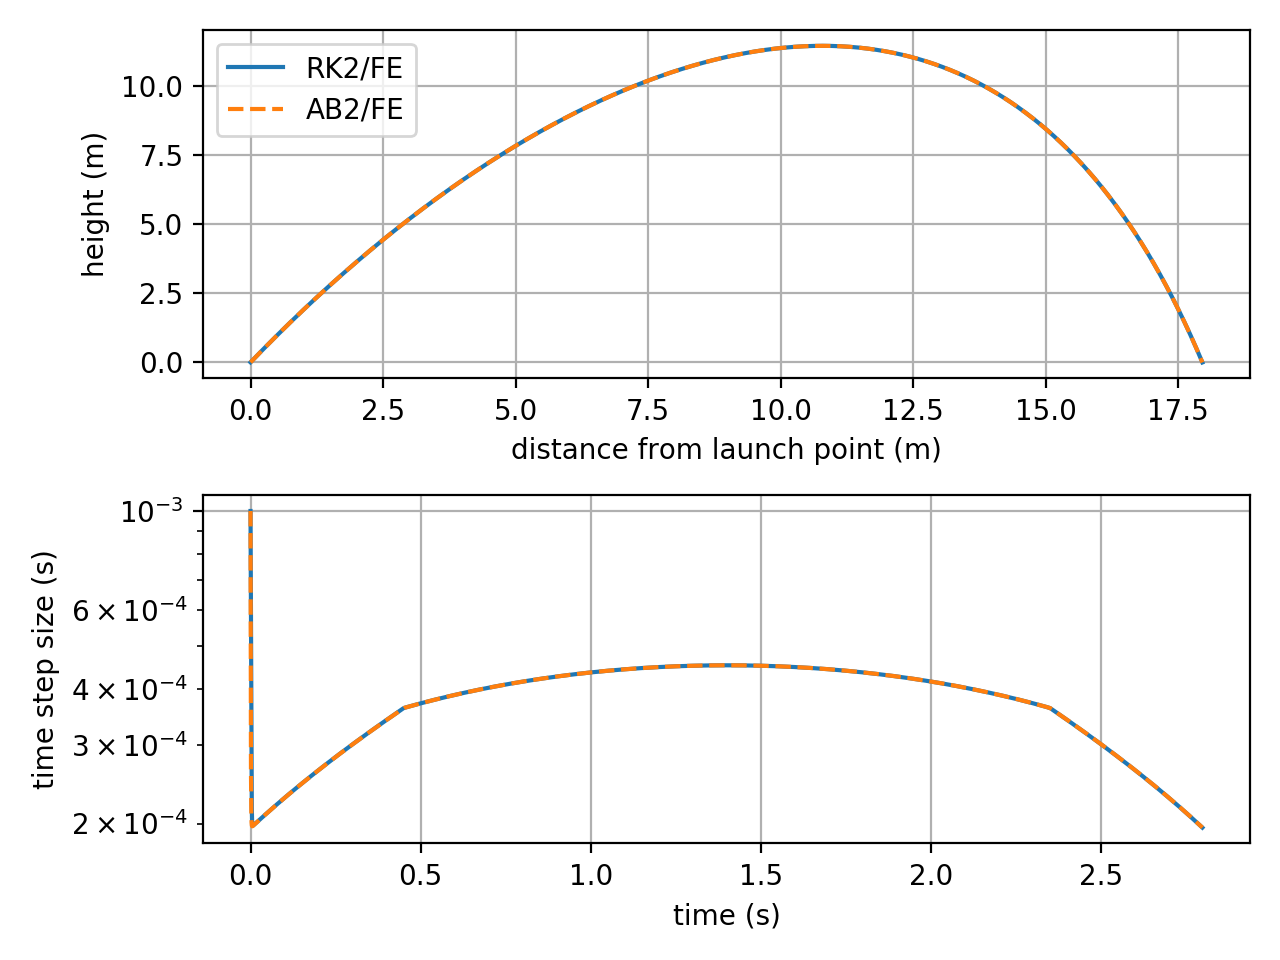

In [8]:
from spitfire import odesolve, AdaptiveERK21HeunEuler, PIController

controller = PIController(target_error=1.e-6, first_step=1.e-3, max_step=1.e-1)

q0 = np.array([0., 0., 10., 20.])  # initial condition
c_d = 20.

t_rk2, q_rk2 = odesolve(lambda t, y: ode_rhs(t, y, c_d),
                        q0,
                        save_each_step=True,
                        step_size=controller,
                        method=AdaptiveERK21HeunEuler(),
                        stop_criteria=object_has_landed)

t_ab2, q_ab2 = odesolve(lambda t, y: ode_rhs(t, y, c_d),
                        q0,
                        save_each_step=True,
                        step_size=controller,
                        method=AB2FE(),
                        stop_criteria=object_has_landed)

%matplotlib notebook

figure, axarray = plt.subplots(2, 1)

axarray[0].plot(q_rk2[:, 0], q_rk2[:, 1], '-', label='RK2/FE')
axarray[0].plot(q_ab2[:, 0], q_ab2[:, 1], '--', label='AB2/FE')
axarray[1].semilogy(t_rk2[:-1], t_rk2[1:] - t_rk2[:-1], '-')
axarray[1].semilogy(t_ab2[:-1], t_ab2[1:] - t_ab2[:-1], '--')

axarray[0].set_xlabel('distance from launch point (m)')
axarray[0].set_ylabel('height (m)')
axarray[1].set_xlabel('time (s)')
axarray[1].set_ylabel('time step size (s)')
for ax in axarray:
    ax.grid()
axarray[0].legend(loc='best')
plt.tight_layout()
plt.show()

# A heuristic to refine $\Delta t$ near the landing point

The following class defines the trapezoidal method that uses forward Euler to obtain an estimate of time error, and which adds in a artificial error multiplier to increase the error when the cannonball is nearing impact with the ground. This is done to refine the time step as we get to the impact point, which is perhaps something we want to resolve more accurately.

In [9]:
class RK2FE_PlusHeuristic(TimeStepper):
    def __init__(self):
        super().__init__(name='ERK2(1) w/trajectory heuristic', order=2)

    def single_step(self, state, t, dt, rhs, *args, **kwargs):
        k1 = rhs(t, state)
        k2 = rhs(t + dt, state + dt * k1)
        weighted_rhs_1 = k1
        weighted_rhs_2 = 0.5 * (k1 + k2)
        temporal_error = np.linalg.norm(dt * (weighted_rhs_2 - weighted_rhs_1), ord=np.Inf)
        
        # now include the heuristic in the error estimate
        y = state[1]
        v_y = state[3]
        temporal_error *= 100. if v_y < 0. and y < 6.0 else 1.
        
        return StepOutput(solution_update=dt * weighted_rhs_2, temporal_error=temporal_error)

Using this method to compute time steps and errors for the PI stepsize controller produces the results below.
Note that the time step drops significantly when the $y$-velocity is negative and the height is below six meters. This should improve accuracy of the method near the landing point, but it really isn't too noticeable here unless you really zoom in. Zooming in _does_ show that time integration terminates at a position much closer to the impact of the cannonball on the ground.

Another thing to think about is that we're using a second-order time integration scheme in this case - if we use a fourth-order scheme the time step will _decrease less_ after we add the artifical error multiplier because the error changes more sharply with the time step size. In the end a better way to get more accuracy out of our time integration is to simply use a higher-order method and a smaller target error - the value of higher-order methods is precisely when an extremely accurate solution is desired. However there may be some cases where artificial error multipliers such as this could be valuable - perhaps around sharp, nonlinear ignition or extinction dynamics in complex chemistry problems (in which case one could add error multipliers based on the temperature or its rate of change, for instance).

<IPython.core.display.Javascript object>


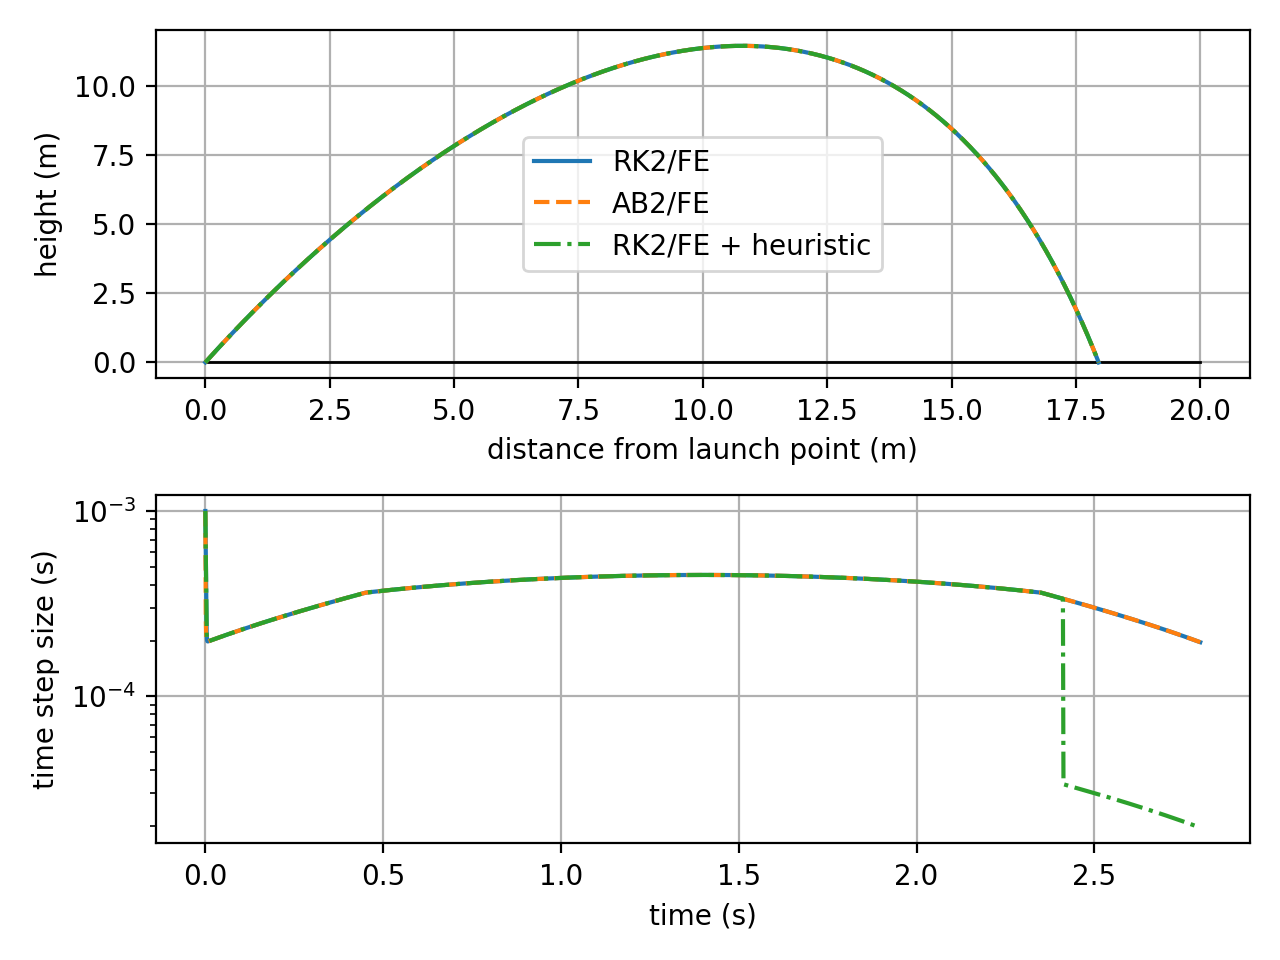

In [10]:
t_rk2mod, q_rk2mod = odesolve(lambda t, y: ode_rhs(t, y, c_d),
                              q0,
                              save_each_step=True,
                              step_size=controller,
                              method=RK2FE_PlusHeuristic(),
                              stop_criteria=object_has_landed)

%matplotlib notebook

figure, axarray = plt.subplots(2, 1)

axarray[0].plot([0, 20], [0, 0], 'k-', linewidth=1)
axarray[0].plot(q_rk2[:, 0], q_rk2[:, 1], '-', label='RK2/FE')
axarray[0].plot(q_ab2[:, 0], q_ab2[:, 1], '--', label='AB2/FE')
axarray[0].plot(q_rk2mod[:, 0], q_rk2mod[:, 1], '-.', label='RK2/FE + heuristic')
axarray[1].semilogy(t_rk2[:-1], t_rk2[1:] - t_rk2[:-1], '-')
axarray[1].semilogy(t_ab2[:-1], t_ab2[1:] - t_ab2[:-1], '--')
axarray[1].semilogy(t_rk2mod[:-1], t_rk2mod[1:] - t_rk2mod[:-1], '-.')

axarray[0].set_xlabel('distance from launch point (m)')
axarray[0].set_ylabel('height (m)')
axarray[1].set_xlabel('time (s)')
axarray[1].set_ylabel('time step size (s)')
for ax in axarray:
    ax.grid()
axarray[0].legend(loc='best')
plt.tight_layout()
plt.show()

## Conclusion

This notebook has shown how to code some user-defined classes that compute embedded error estimates to drive adaptive time-stepping. In one example a classical variable-step second-order Adams-Bashforth method was implemented, and in the other we use a Runge-Kutta method with both a rigorous error estimate and an additional error from a heuristic based on specific details of the differential equations being solved.